In [21]:
# 1. IMPORT LIBRARY
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random
from tensorflow.keras.preprocessing import image
from PIL import Image


In [53]:
# 2. PARAMETER DAN DATA GENERATOR
from tensorflow.keras.applications.efficientnet import preprocess_input
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    r"..\dataset\FishImgDataset\train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    r"..\dataset\FishImgDataset\val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = train_gen.num_classes
class_names = list(train_gen.class_indices.keys())

Found 3520 images belonging to 8 classes.
Found 1185 images belonging to 8 classes.


In [26]:
#4. MODEL EfficientNetB0
from tensorflow.keras.layers import BatchNormalization

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # freeze backbone

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(base_model.input, output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 224, 224,  │          7 │ rescaling_8[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_9         │ (None, 224, 224,  │          0 │ normalization_4[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_9[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,384,683 (16.73 MB)

 Trainable params: 332,552 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [27]:
# 5. TRAINING + EARLY STOPPING
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stopping]
)


Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.5585 - loss: 1.3954 - val_accuracy: 0.8177 - val_loss: 0.9069
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8128 - loss: 0.5847 - val_accuracy: 0.9089 - val_loss: 0.4333
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8739 - loss: 0.4094 - val_accuracy: 0.9426 - val_loss: 0.2509
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9000 - loss: 0.3247 - val_accuracy: 0.9544 - val_loss: 0.1727
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.9179 - loss: 0.2717 - val_accuracy: 0.9637 - val_loss: 0.1337
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.9236 - loss: 0.2350 - val_accuracy: 0.9688 - val_loss: 0.1055
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9415 - loss: 0.1913 - val_accuracy: 0.9722 - val_loss: 0.0892
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9480 - loss: 0.1662 - val_accu

In [ ]:
# 6. SIMPAN MODEL TERBAIK
def save_best_model(model, history, model_name):
    import os

    # keluar dari folder notebook → masuk folder model
    save_dir = os.path.join("..", "model")
    os.makedirs(save_dir, exist_ok=True)

    # ambil val_accuracy terbaik
    best_val_acc = max(history.history['val_accuracy'])

    save_path = os.path.join(
        save_dir,
        f"{model_name}_valacc_{best_val_acc:.4f}.h5"
    )

    model.save(save_path)

    print(f"Best model '{model_name}' disimpan di:")
    print(os.path.abspath(save_path))



In [38]:
save_best_model(model, history, "efficientnet_classifier")

Model berhasil disimpan di:
d:\Semester 7\mesin learning\Praktikum\uap\notebook\model\efficientnet_classifier_valacc_0.9958.h5


In [39]:
# 7. EVALUASI MODEL
def evaluate_model(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred = np.argmax(y_pred, axis=1)

    print(classification_report(
        y_true, y_pred,
        target_names=generator.class_indices.keys()
    ))
    return y_true, y_pred


y_true, y_pred = evaluate_model(model, val_gen)


38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step
                precision    recall  f1-score   support

       Catfish       0.99      1.00      0.99        97
Glass Perchlet       0.99      1.00      1.00       124
          Goby       0.99      1.00      1.00       189
       Gourami       1.00      1.00      1.00        97
    Grass_Carp       0.99      1.00      1.00       378
     Knifefish       1.00      0.99      0.99       100
   Silver Barb       0.99      0.97      0.98       105
       Tilapia       1.00      0.99      0.99        95

      accuracy                           0.99      1185
     macro avg       1.00      0.99      0.99      1185
  weighted avg       0.99      0.99      0.99      1185



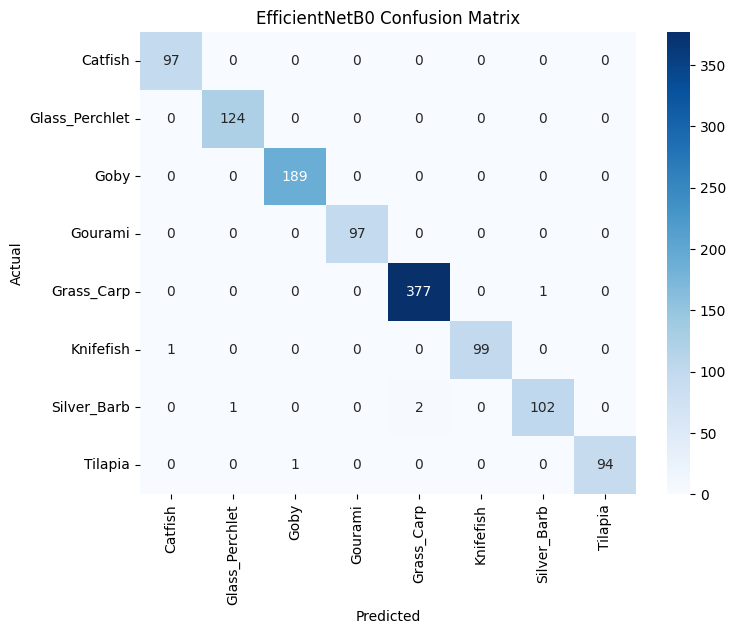

In [ ]:
# 8. CONFUSION MATRIX
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


plot_confusion(y_true, y_pred, "EfficientNetB0 Confusion Matrix")


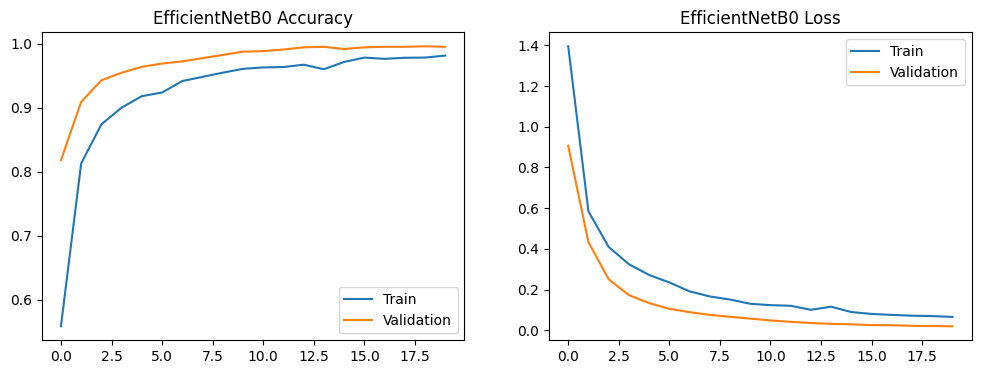

In [42]:
# 9. PLOT HISTORY
def plot_history(history, title):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title(f"{title} Accuracy")
    plt.legend(["Train", "Validation"])

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title(f"{title} Loss")
    plt.legend(["Train", "Validation"])

    plt.show()


plot_history(history, "EfficientNetB0")


In [43]:
# 10. PILIH 10 GAMBAR RANDOM DARI TEST
test_dir = r"..\dataset\FishImgDataset\test"

all_images = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            all_images.append(os.path.join(class_path, img_name))

random_samples = random.sample(all_images, 3)


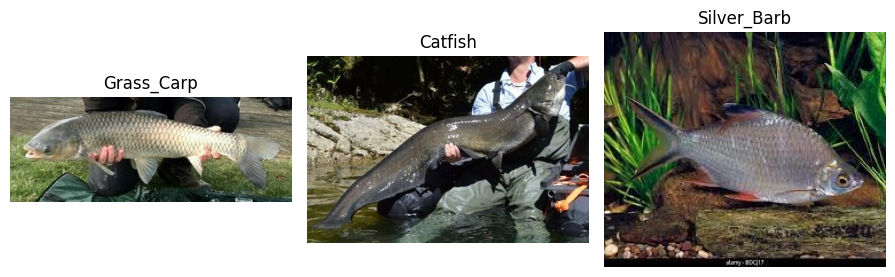

In [46]:
# 11. PILIH 3 GAMBAR SECARA ACAK DARI DATA TEST

import os
import random

test_dir = r"..\dataset\FishImgDataset\test"
# ambil semua path gambar di folder test
all_images = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            all_images.append(os.path.join(class_path, img_name))

# pilih gambar secara acak
random_samples = random.sample(all_images, 3)


import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(15, 8))

for i, img_path in enumerate(random_samples):
    img = Image.open(img_path)

    plt.subplot(2, 5, i+1)
    plt.imshow(img)

    # ambil nama kelas dari folder
    class_name = os.path.basename(os.path.dirname(img_path))
    plt.title(class_name)

    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


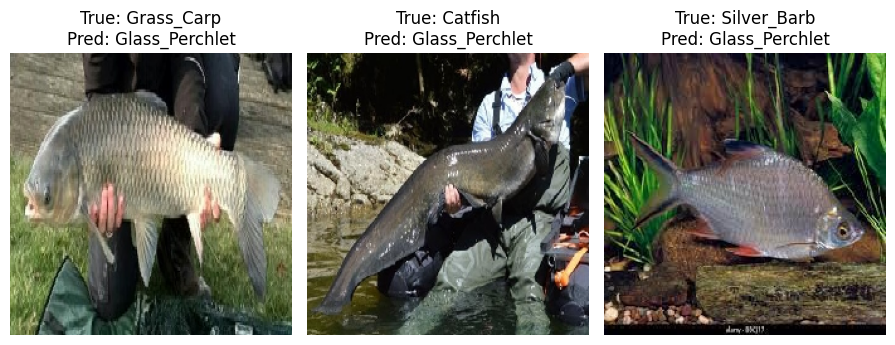

In [55]:
# 12. TRUE LABEL vs PREDIKSI 
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

class_names = list(train_gen.class_indices.keys())

plt.figure(figsize=(15, 8))

for i, img_path in enumerate(random_samples):

    # load & preprocess
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # prediksi
    pred = model.predict(img_array)
    pred_class = np.argmax(pred)   # ✅ DI SINI didefinisikan

    # label
    true_label = os.path.basename(os.path.dirname(img_path))
    pred_label = class_names[pred_class]

    # plot
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

